In [66]:
# imports
import numpy as np
import krakenex as k
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import time
import datetime
from pathlib import Path
import sys
from datetime import datetime, timedelta
from matplotlib import dates 
import IPython.core.debugger
dbg = IPython.core.debugger.Pdb()
#dbg.set_trace() #colocar dondo punto interrupcion
import matplotlib.dates as mdates
import matplotlib.ticker as mticker

import time
start = time.time()


In [67]:
#set SQL BBDD
from sqlalchemy import create_engine, MetaData, Table, Column, DateTime, Float, String,Integer

dbInstance = 'sqlite:///krakenTeader.db'
dbBalanceHistoryTable = 'BalanceHistory'
dbTradesHistoryTable = 'TradesHistory'
dbMyTradesTable = 'MyTrades'
dbTradesCondensationTable = 'TradesCondensation'

engine = create_engine(dbInstance)

if not engine.dialect.has_table(engine, dbMyTradesTable):  # If table don't exist, Create.
    metadata = MetaData(engine)
    
    # Create a table with the appropriate Columns
    Table(dbMyTradesTable, metadata,
             Column('id', Integer, nullable=True), 
             Column('openTime', DateTime, nullable=True), 
             Column('closeTime', DateTime, nullable=True), 
             Column('tradeDescription', String, nullable=True), 
             
             Column('OpeningTypeID', Integer, nullable=True), 
             Column('ClosingTypeID', Integer, nullable=True), 
          
             Column('openingCH', Float, nullable=True), 
             Column('baseCH', Float, nullable=True), 
             Column('targetCH', Float, nullable=True), 
             Column('stopLoseCH', Float, nullable=True), 
             Column('TotalLoseCH', Float, nullable=True), 
             Column('closingCH', Float, nullable=True), 
             Column('deltaCH', Float, nullable=True), 
             
             Column('openingP', Float, nullable=True), 
             Column('baseP', Float, nullable=True), 
             Column('targetP', Float, nullable=True), 
             Column('stopLoseP', Float, nullable=True), 
             Column('TotalLoseP', Float, nullable=True), 
             Column('closingP', Float, nullable=True), 
             Column('deltaP', Float, nullable=True), 
          
             Column('Profit', Float, nullable=True),
             Column('Profit_Gastos', Float, nullable=True))
    # Implement the creation
    metadata.create_all() 
    
if not engine.dialect.has_table(engine, dbTradesCondensationTable):  # If table don't exist, Create.
    metadata = MetaData(engine)
    
    # Create a table with the appropriate Columns
    Table(dbTradesCondensationTable, metadata,
             Column('time', DateTime, nullable=True), 
             Column('price', Float, nullable=True), 
             Column('countb', Float, nullable=True), 
             Column('volb', Float, nullable=True), 
             Column('counts', Float, nullable=True), 
             Column('vols', Float, nullable=True))
    # Implement the creation
    metadata.create_all()

"""  
import sqlite3 as sql
conn = sql.connect('krakenTeader.db')
c = conn.cursor()
#mydata = c.execute("DELETE FROM TradesCondensation WHERE time=?", ("2102-05-08 07:47:11.736900",))
mydata = c.execute("DELETE FROM TradesCondensation")
conn.commit()
c.close;
"""

'  \nimport sqlite3 as sql\nconn = sql.connect(\'krakenTeader.db\')\nc = conn.cursor()\n#mydata = c.execute("DELETE FROM TradesCondensation WHERE time=?", ("2102-05-08 07:47:11.736900",))\nmydata = c.execute("DELETE FROM TradesCondensation")\nconn.commit()\nc.close;\n'

In [68]:

#preparar datos para plotear
BalanceHistory = pd.read_sql(dbBalanceHistoryTable, con=engine)
BalanceHistory = BalanceHistory.set_index(pd.DatetimeIndex(BalanceHistory['Time']))
BalanceHistory.drop('Time', axis=1,inplace=True)

#filtrar periodo de interes
windowTime = (24 * 51) + 21
EndSampleTime = datetime(2017,12,2,20,55,)
plotmin = True
HoursInterval = 1
if windowTime > 6: plotmin = False
if windowTime > 12: HoursInterval = 2
if windowTime > 24: HoursInterval = 4
if windowTime > 24 * 2: HoursInterval = 8
if windowTime > 24 * 5: HoursInterval = 12
if windowTime > 24 * 10: HoursInterval = 24
if windowTime > 24 * 15: HoursInterval = 48
if windowTime > 24 * 30: HoursInterval = 96

verUltimo=False
startSampleTime = datetime.now() + timedelta(hours=windowTime*-1)
if verUltimo:
    BalanceHistory = BalanceHistory[BalanceHistory.index > startSampleTime]
else:
    startSampleTime = EndSampleTime + timedelta(hours=windowTime*-1)
    BalanceHistory = BalanceHistory[(BalanceHistory.index >= startSampleTime) & (BalanceHistory.index <= EndSampleTime)]

#combertir el balance a un porcentaje entre -100% y 100%
BalanceHistory['balanceRatio'] = (BalanceHistory['balanceRatio'] - 0.5 )*2*100 

BalanceHistory['volbuy'] = BalanceHistory['volbuy'] / BalanceHistory['close']
BalanceHistory['volsell'] = BalanceHistory['volsell'] / BalanceHistory['close']
BalanceHistory['unbalance'] = BalanceHistory['unbalance'] / BalanceHistory['close']

#calcular %CH, %CH Acum , SMA %CH Acum
BalanceHistory['change'] = BalanceHistory['close'].pct_change(periods=1)*100
#BalanceHistory['cahnge2'] = BalanceHistory['close'] / BalanceHistory['close'].shift(1) -1 #equibalente 
BalanceHistory['cum_change'] = BalanceHistory['change'].cumsum()
BalanceHistory['SMA03_cum_change'] = BalanceHistory['cum_change'].rolling(5).mean()
BalanceHistory['SMA12_cum_change'] = BalanceHistory['cum_change'].rolling(12).mean()

#calcular sma de 3 periodos (suavisar el grafico)
BalanceHistory['EWM_unbalance'] =  BalanceHistory["unbalance"].ewm(span=3).mean()

#calcular la porsiocn negativa (para mostrar en rojo en el grafico)
BalanceHistory['EWM_unbalance_N'] = BalanceHistory['EWM_unbalance']
neg = BalanceHistory['EWM_unbalance_N']
neg[neg >= 0] = np.nan
BalanceHistory['EWM_unbalance_N'] = neg


comCompra = 0.29  
comVenta = 0.19 
spreadEntrada = 0.2 
spreadSalida = 0.2
deltaBaseCH = comCompra + comVenta + spreadEntrada + spreadSalida 

In [69]:
def Condensatetrades(InsertT0):
    
    #leer trades history
    tradesHistory = pd.read_sql(dbTradesHistoryTable, con=engine)
    tradesHistory.set_index(pd.DatetimeIndex(tradesHistory['time']),inplace=True)
    tradesHistory = tradesHistory[(tradesHistory.index >= startSampleTime) & (tradesHistory.index <= EndSampleTime)]
    
    #crear tataframe para condensar trades
    tradesCondensation =  pd.DataFrame(columns=['time','price','countb','volb','counts','vols'])
    
    #leer ultima condensasion conosida
    lastKnowCondensationTime = BalanceHistory.index[0]
    if  engine.dialect.has_table(engine, dbTradesCondensationTable):
        tradesCondensationBBDD = pd.read_sql(dbTradesCondensationTable, con=engine)
        if len(tradesCondensationBBDD) > 0:
            lastKnowCondensationTime = tradesCondensationBBDD['time'][len(tradesCondensationBBDD)-1]
    
    # filtrar trades y balance mayor a la ultima fecha conosida
    BalanceHistoryToCondens = BalanceHistory[BalanceHistory.index >= lastKnowCondensationTime]
    tradesHistoryToCondens = tradesHistory[tradesHistory.index >= lastKnowCondensationTime]
    BalanceHistoryToCondens = BalanceHistoryToCondens.sort_index()
    tradesHistoryToCondens = tradesHistoryToCondens.sort_index()
    #condensa, si existen datos para condensar 
    if (len(tradesHistoryToCondens) > 0) & (len(BalanceHistoryToCondens) > 0):
        for i in range(len(BalanceHistoryToCondens)):
            t0 = BalanceHistoryToCondens.index[i]
            if i > 0:
                t1 = BalanceHistoryToCondens.index[i-1]

                trades0 = tradesHistoryToCondens[t1:t0]

                trades0b = trades0[trades0['buy_sell'] =='b']
                trades0s = trades0[trades0['buy_sell'] =='s']

                tradesCountb = len(trades0b)
                tradesCounts = len(trades0s)*-1

                price = trades0.price.mean()
                if price == 0:
                    price = tradesHistoryToCondens.index[i-1]

                volb = trades0b.volume.sum()
                vols = trades0s.volume.sum()*-1

                new = [t0,price,tradesCountb,volb,tradesCounts,vols]
                tradesCondensation.loc[len(tradesCondensation)] = new
            else:
                if InsertT0 == True:
                    new = [t0,0.0,0,0.0,0,0.0]
                    tradesCondensation.loc[len(tradesCondensation)] = new
        #end for
        
        #si exisnten datos
        if (len(tradesCondensation) > 0):
            tradesCondensation.fillna(0,inplace=True)
            tradesCondensation.set_index(pd.DatetimeIndex(tradesCondensation['time']),inplace=True)
            tradesCondensation.drop('time',inplace=True,axis=1)
            
        #guardar en bbdd, si existen datos condensados de fecha mayor a al ultima condensacion conosida
        if len(tradesCondensation[tradesCondensation.index > lastKnowCondensationTime]) > 0:
            tradesCondensation.to_sql(dbTradesCondensationTable,engine, if_exists='append')
    
    #leer y retornar condensasion desde la bbdd
    tc = pd.read_sql(dbTradesCondensationTable, con=engine)
    tc.set_index(pd.DatetimeIndex(tc['time']),inplace=True)
    tc.drop('time',inplace=True,axis=1)
    tc = tc[(tc.index >= startSampleTime) & (tc.index <= EndSampleTime)]
    return tc

In [70]:
tradesCondensation = Condensatetrades(False)

In [71]:
def restarGastos (s):
    l = []
    for i in range(len(s)):
            l.append((s[i+1] - (deltaBaseCH*(i+1)) ))
    return l

def plotProfit():
    if len(myTrades) > 0:
        myTrades['Profit'] = myTrades['deltaCH'].cumsum()
        myTrades['Profit_Gastos'] = restarGastos(myTrades['Profit'])
        totalCom = len(myTrades) * deltaBaseCH
        totalWin = myTrades.deltaCH.sum()
        finalBalance = totalWin - totalCom
        print('total win: {0}, total commiciones: {1}, Balance Final {2}'.format( totalWin,totalCom,finalBalance))
        if len(myTrades) > 1:
            myTrades['Profit'].plot()   
            myTrades['Profit_Gastos'].plot()

In [72]:
def plotHistory(plotVolume=False, plotTrades=False):
    fig,ax = plt.subplots( sharex=True, figsize=(16,14), nrows=4, ncols=1)

    #plot price
    ax[0].plot_date(BalanceHistory.index, BalanceHistory['close'],'orange',marker='o', markersize=1)
    ax[0].yaxis.grid(True) 
    ax[0].xaxis.grid(True) 
    ax[0].xaxis.set_major_locator(dates.HourLocator(interval=HoursInterval)) 
    ax[0].xaxis.set_major_formatter(dates.DateFormatter('\n %d-%m %H'))
    if plotmin ==True:
        ax[0].xaxis.set_minor_locator(dates.MinuteLocator(interval=5))
        ax[0].xaxis.set_minor_formatter(dates.DateFormatter('%M'))
        ax[0].xaxis.grid(b=True, which='minor', color='grey', linestyle='--')

    ax[0].set_title('CLOSE')
    ax[0].legend(loc='best')

    #plot %CH short SMA Large SMA
    ax[1].plot_date(BalanceHistory.index, BalanceHistory['change'],'ro-', markersize=1)
    ax[1].plot_date(BalanceHistory.index, BalanceHistory['cum_change'],'b-')
    ax[1].plot_date(BalanceHistory.index, BalanceHistory['SMA03_cum_change'],'go-', markersize=1,alpha=0.6) #ligthBlue
    ax[1].yaxis.grid(True) 
    ax[1].xaxis.grid(True) 
    ax[1].xaxis.set_major_locator(dates.HourLocator(interval=HoursInterval)) 
    ax[1].xaxis.set_major_formatter(dates.DateFormatter('\n %d-%m %H'))
    if plotmin ==True:
        ax[1].xaxis.set_minor_locator(dates.MinuteLocator(interval=5))
        ax[1].xaxis.set_minor_formatter(dates.DateFormatter('%M'))
        ax[1].xaxis.grid(b=True, which='minor', color='grey', linestyle='--')

    ax[1].set_title('% CHANGE - CUMULATIVE CHANGE')
    ax[1].legend(loc='best')
    ax[1].axhline(0,color='g',ls='-')

    #plot  MarquetBalance
    ax[2].plot_date(BalanceHistory.index, BalanceHistory['volbuy'],'g--',alpha=0.5)
    ax[2].plot_date(BalanceHistory.index, BalanceHistory['volsell'],'r--',alpha=0.5) 
    #ax[2].plot_date(BalanceHistory.index, BalanceHistory['unbalance'],'bo-', markersize=3)
    ax[2].plot_date(BalanceHistory.index, BalanceHistory['EWM_unbalance'],'bo-', markersize=1)
    ax[2].plot_date(BalanceHistory.index, BalanceHistory['EWM_unbalance_N'],'ro-', markersize=1)

    ax[2].yaxis.grid(True) 
    ax[2].xaxis.grid(True) 
    ax[2].xaxis.set_major_locator(dates.HourLocator(interval=HoursInterval)) 
    ax[2].xaxis.set_major_formatter(dates.DateFormatter('\n %d-%m %H'))
    if plotmin ==True:
        ax[2].xaxis.set_minor_locator(dates.MinuteLocator(interval=5))
        ax[2].xaxis.set_minor_formatter(dates.DateFormatter('%M'))
        ax[2].xaxis.grid(b=True, which='minor', color='grey', linestyle='--')

    ax[2].set_title('volbuy - volsell- unbalance')
    ax[2].legend(loc='best')
    #ax[2].axhline(0,color='g',ls='-')

    # plot volumen
    if plotVolume == True:
        ax[3].plot_date(tradesCondensation.index, tradesCondensation['volb'],'g',marker='o', markersize=3)
        ax[3].plot_date(tradesCondensation.index, tradesCondensation['vols'],'r',marker='o', markersize=3)
        ax[3].yaxis.grid(True) 
        ax[3].xaxis.grid(True) 
        ax[3].xaxis.set_major_locator(dates.HourLocator(interval=HoursInterval)) 
        ax[3].xaxis.set_major_formatter(dates.DateFormatter('\n %d-%m %H'))
        if plotmin ==True:
            ax[3].xaxis.set_minor_locator(dates.MinuteLocator(interval=5))
            ax[3].xaxis.set_minor_formatter(dates.DateFormatter('%M'))
            ax[3].xaxis.grid(b=True, which='minor', color='grey', linestyle='--')

        ax[3].set_title('VOLUMEN POR PERIODO')
        ax[3].legend(loc='best')
        ax[3].axhline(0,color='g',ls='-')

    if plotTrades == True:
        cont = 1
        for d in  myTrades.openTime:        
            ax[1].annotate(cont , xy=(d,1))
            ax[0].axvline(d,ymin=-1.2,ymax=1,c="#05652F",linewidth=2,zorder=0, clip_on=False)
            ax[1].axvline(d,ymin=-1.2,ymax=1,c="#05652F",linewidth=2,zorder=0, clip_on=False)
            ax[2].axvline(d,ymin=-1.2,ymax=1,c="#05652F",linewidth=2,zorder=0, clip_on=False)
            ax[3].axvline(d,ymin=0,ymax=1,c="#05652F",linewidth=2,zorder=0, clip_on=False)
            cont += 1

        for d in myTrades.closeTime:
            ax[0].axvline(d,ymin=-1.2,ymax=1,c="#ffaa80",linewidth=2,zorder=0, clip_on=False)
            ax[1].axvline(d,ymin=-1.2,ymax=1,c="#ffaa80",linewidth=2,zorder=0, clip_on=False)
            ax[2].axvline(d,ymin=-1.2,ymax=1,c="#ffaa80",linewidth=2,zorder=0, clip_on=False)
            ax[3].axvline(d,ymin=0,ymax=1,c="#ffaa80",linewidth=2,zorder=0, clip_on=False)


In [73]:
def plotAllTrades():
    tradesCount = len(myTrades)
    if tradesCount > 0:
        fig, axes = plt.subplots(tradesCount, 2, figsize=(16,tradesCount*5), squeeze=False)
        for i in range(tradesCount):
            n = i+1
            row = axes[i]
            dOpen = myTrades.openTime[n]
            iniPos = BalanceHistory.index.get_loc(dOpen)-5
            iniMoment = BalanceHistory.index[iniPos] 

            sDesc = myTrades.tradeDescription[n]
            
            dClose = myTrades.closeTime[n]
            endPos = BalanceHistory.index.get_loc(dClose)+5
            maxPos  = len(BalanceHistory)
            if endPos >= maxPos:
                endPos = maxPos-1
            
            endMoment = BalanceHistory.index[endPos] 
            
            df =  BalanceHistory[(BalanceHistory.index >= iniMoment) & (BalanceHistory.index <= endMoment)]

            #calcular %CH, %CH Acum , SMA %CH Acum
            #df['change'] = df['close'].pct_change(periods=1)*100
            #df['cum_change'] = df['change'].cumsum()
            #df['SMA03_cum_change'] = df['cum_change'].rolling(3).mean()
            #df['SMA12_cum_change'] = df['cum_change'].rolling(12).mean()
            plotTrade(row, df,dOpen, dClose, sDesc,myTrades.openingCH[n],myTrades.closingCH[n])

        fig.autofmt_xdate() 
        plt.legend() 
        plt.tight_layout() 
        plt.show()
    else:
        print('No trades for plot')

def plotTrade(ax, df, dOpen, dClose, sDesc, openCH,closeCH):
    intervalo = int(HoursInterval/4)
    if intervalo == 0: intervalo = 1
    locator = mdates.HourLocator(interval=intervalo)
    locator.MAXTICKS = 10000

    ax[0].plot_date(df.index, df['volbuy'],'g--',alpha=0.5)
    ax[0].plot_date(df.index, df['volsell'],'r--',alpha=0.5)
    ax[0].plot_date(df.index, df['unbalance'],'bo-', markersize=3)
    #ax[0].plot_date(df.index, df['EWM_unbalance'],'bo-', markersize=3)
    #ax[0].plot_date(df.index, df['EWM_unbalance_N'],'ro-', markersize=3)
    ax[0].axvline(dOpen,ymin=-0,ymax=1,c="#05652F",linewidth=2,zorder=0)
    ax[0].axvline(dClose,ymin=-0,ymax=1,c="#F44C04",linewidth=2,zorder=0)
    ax[0].yaxis.grid(True) 
    ax[0].xaxis.grid(True) 
    ax[0].xaxis.set_major_locator(locator)
    ax[0].xaxis.set_major_formatter(dates.DateFormatter('%d %H'))
    ax[0].yaxis.set_major_locator(mticker.AutoLocator())
    ax[0].xaxis.grid(b=True, which='mayor', color='grey', linestyle='--')
    ax[0].legend(loc='best')
    ax[0].axhline(0,color='g',ls='-')
    ax[0].set_title(sDesc)

    ax[1].plot_date(df.index, df['cum_change']- openCH,'b-')
    ax[1].plot_date(df.index, df['SMA03_cum_change']- openCH,'go-', markersize=2,alpha=0.8)
    ax[1].plot_date(df.index, df['SMA12_cum_change'] - openCH,'o-',color='#3366ff', markersize=2,alpha=0.8) #ligthBlue
    ax[1].axvline(dOpen,ymin=-0,ymax=1,c="#05652F",linewidth=2,zorder=0)
    ax[1].axvline(dClose,ymin=-0,ymax=1,c="#F44C04",linewidth=2,zorder=0)
    
    ax[1].axhline(openCH - openCH,xmin=-0,xmax=1,c="#05652F",linewidth=2,zorder=0)
    ax[1].axhline(closeCH - openCH,xmin=-0,xmax=1,c="#F44C04",linewidth=2,zorder=0)
    
    ax[1].yaxis.grid(True) 
    ax[1].xaxis.grid(True) 
    ax[1].xaxis.set_major_locator(locator)
    ax[1].xaxis.set_major_formatter(dates.DateFormatter('%d %H'))
    ax[1].yaxis.set_major_locator(mticker.AutoLocator())
    ax[1].xaxis.grid(b=True, which='mayor', color='grey', linestyle='--')
    ax[1].legend(loc='best')
    ax[1].axhline(0,color='b',ls='-')

In [74]:
def obtenerMaximo(m,ch):
    if m >= ch: 
        return m
    else:
        return ch 
    
def  acumular(serie,cant,pos):
    su = 0.0
    for i in range(pos,pos - cant - 1,-1):
        su = su + serie[i]
    return su
    
    
def upTrend (bh, td, volPriceOpen = 40000, chOpen = 0.5, mbOpen = 0.5, deltaCHObjetivo = 5, chClose = 1, deltaTotalLoseCH = 0.5, waitPeriods = 60, waitFactor = 48, waitPeriodsOutBase = 30, waitFactorOutBase = 6):

    comCompra = 0.29  
    comVenta = 0.19 
    spreadEntrada = 0.2 
    spreadSalida = 0.2
    deltaBaseCH = comCompra + comVenta + spreadEntrada + spreadSalida 

    deltaTargetCH = deltaBaseCH + deltaCHObjetivo
    deltaStopLose = deltaBaseCH - chClose

    inBase = False
    
    s = bh['unbalance']
    sma03 = bh['SMA03_cum_change']
    sma12 = bh['SMA12_cum_change']
    ch = bh['change']
    cumch = bh['cum_change']
    
    volb = td['volb']
    vols = td['vols']
    
    openPos = 0
    isOpen = False
    inBase = False
        
    sOpenCond = ""
    sCloseCond = ""
        
    #valores de cada operacion 
    openingCH = 0.0
    baseCH = 0.0
    targetCH = 0.0
    stopLoseCH = 0.0
    TotalLoseCH = 0.0
    closingCH = 0.0
    deltaCH = 0.0
    idTrade = 0
    openTime = datetime.now()
    closeTime =openTime
    maximo = 0.0
    toleranciaMaximo = 0.6
    maximoTolerado = 0.0
    cantAcumular = 4
    volAcumulado = 0.0
    mbAcumulado = 0.0
    
    OpeningTypeID = 0
    ClosingTypeID = 0
    openingP = 0.0
    baseP = 0.0
    targetP = 0.0
    stopLoseP = 0.0
    TotalLoseP = 0.0
    closingP = 0.0
    deltaP = 0.0
    
    cols = ['id', 'openTime', 'closeTime', 'tradeDescription', 'OpeningTypeID', 'ClosingTypeID', 'openingCH', 'baseCH', 'targetCH', 'stopLoseCH', 'TotalLoseCH', 'closingCH', 'deltaCH', 'openingP', 'baseP', 'targetP', 'stopLoseP', 'TotalLoseP', 'closingP', 'deltaP', 'Profit', 'Profit_Gastos']     
    myTrades = pd.DataFrame(columns=cols)
    
    for i in range(len(s)):
        if i > 12:
            if (isOpen == False):
                if i < len(td):
                    #volAcumulado = acumular(volb,5,i)
                    #mbAcumulado = acumular(s,5,i)
                    #(volb[i] * td['price'][i] >= volPriceOpen) | (volAcumulado * td['price'][i] >= volPriceOpen):
                    if(volb[i] * td['price'][i] >= volPriceOpen):
                        if (s[i] > 0) & (s[i-1] < 0):
                            if (sma03[i] > sma03[i-1]+ chOpen):
                                isOpen = True
                                sOpenCond = "MB UP 1"
                                OpeningTypeID = 1
                        elif (s[i] > 0) & (s[i] > mbOpen):
                            isOpen = True
                            sOpenCond = "MB UP 2"
                            OpeningTypeID = 2
                        elif (s[i] < 0) & (s[i-1] > s[i-2] + mbOpen*2):
                            isOpen = True
                            sOpenCond = "MB UP 3"
                            OpeningTypeID = 3
                        #elif (mbAcumulado >= mbOpen*2):
                        #    isOpen = True
                        #    sOpenCond = "MB Acumulado"
                        elif ((sma03[i-1] < sma12[i-1]) & (sma03[i] > sma12[i])): 
                            if (sma03[i] > sma03[i-1]+ chOpen):
                                isOpen = True
                                sOpenCond = "SMA03 UP"
                                OpeningTypeID = 4
                        elif (ch[i] > ch[i-1] + chOpen): 
                            if (sma03[i] > sma03[i-1]+ chOpen):
                                isOpen = True
                                sOpenCond = "CH UP"
                                OpeningTypeID = 5
                if isOpen == True:
                    openPos = i
                    idTrade = idTrade + 1
                    sDesc = '({0}) ─► {1}'.format(idTrade, sOpenCond)
                    inBase = False
                    openTime = s.index[i]
                    openingCH = cumch[i]
                    baseCH = openingCH + deltaBaseCH
                    targetCH = openingCH + deltaTargetCH
                    stopLoseCH = openingCH + deltaStopLose
                    TotalLoseCH = openingCH - deltaTotalLoseCH
                    
                    openingP =  td['price'][i]
                    baseP = openingP * ((100+deltaBaseCH)/100)
                    targetP = openingP * ((100+deltaTargetCH)/100)
                    stopLoseP = openingP * ((100+deltaStopLose)/100)
                    TotalLoseP = openingP * ((100+deltaTotalLoseCH)/100)
                    
                    
            if (isOpen == True):
                if bh.cum_change[i] >= baseCH: #nivel de perdidas operacionales superado
                    inBase = True
                if inBase == True: 
                    currentCumCH = cumch[i] -  openingCH
                    maximo = obtenerMaximo(maximo,currentCumCH)
                    if (maximo < deltaCHObjetivo):
                        if (maximo >= deltaStopLose) & (maximo < deltaCHObjetivo *0.25):  maximoTolerado = deltaStopLose    
                        elif (maximo >= deltaCHObjetivo *0.25) & (maximo < deltaCHObjetivo *0.5): maximoTolerado = deltaStopLose + 1.2
                        elif (maximo >= deltaCHObjetivo *0.5) & (maximo < deltaCHObjetivo *0.75): maximoTolerado = deltaStopLose + 4.5
                        elif (maximo >= deltaCHObjetivo *0.75) & (maximo < deltaCHObjetivo): maximoTolerado = deltaStopLose + 6.5                    
                    else:
                        if (maximo >= deltaCHObjetivo) & (maximo < deltaCHObjetivo *1.25):        maximoTolerado = deltaCHObjetivo * 0.9
                        elif (maximo >= deltaCHObjetivo *1.25) & (maximo < deltaCHObjetivo *1.5):  maximoTolerado = deltaCHObjetivo * 1.1
                        elif (maximo >= deltaCHObjetivo *1.5)  & (maximo < deltaCHObjetivo *1.75): maximoTolerado = deltaCHObjetivo * 1.4      
                        elif (maximo >= deltaCHObjetivo *1.75) & (maximo < deltaCHObjetivo *2):    maximoTolerado = deltaCHObjetivo * 1.6
                        elif (maximo >= deltaCHObjetivo *2)    & (maximo < deltaCHObjetivo *2.5):  maximoTolerado = deltaCHObjetivo *1.8
                        elif (maximo >= deltaCHObjetivo *2.5): maximoTolerado = deltaCHObjetivo *2.1
                        
                    if (currentCumCH <= maximoTolerado):
                            isOpen = False
                            sCloseCond = "Maximo AT {0} %CH, Tolerado AT {1} %CH".format(round(maximo,2), round(maximoTolerado,2))
                            ClosingTypeID = 1
                    if cumch[i] <= (stopLoseCH): #cierre por stop lose
                        isOpen = False
                        sCloseCond = "STOP LOSE AT {0} %CH".format(round(deltaStopLose,2))
                        ClosingTypeID = 2
                    elif (i >= (openPos + waitPeriods*waitFactor)): #cierre por tiempo trascurrido sin logar objetivos
                        isOpen = False
                        sCloseCond = "elapsed {0} times without goals | IN BASE".format(waitPeriods*waitFactor)
                        ClosingTypeID = 3
                    #elif currentCumCH < maximo:
                    #    if (cumch[i] >= targetCH) & (currentCumCH <= maximo*0.95): #objetivo cumplido
                    #        if s[i] < mbOpen: #dejar correr las ganancias
                    #            isOpen = False
                    #            sCloseCond = "TARGET ACOMPLISH AT {0} %CH".format(round(currentCumCH,2))
                    
                else: #nivel de perdidas operacionales no se logro 
                    if (s[i] <= 0) &(cumch[i] < TotalLoseCH): #cierre por perdida total
                        isOpen = False
                        sCloseCond = "TOTAL LOSE"
                        ClosingTypeID = 4
                    elif (i >= (openPos + waitPeriodsOutBase*waitFactorOutBase)): #cierre por tiempo trascurrido sin logar objetivos
                        isOpen = False
                        sCloseCond = "elapsed {0} times without goals | OUT BASE".format(waitPeriodsOutBase*waitFactorOutBase)
                        ClosingTypeID = 5
                
                if isOpen == False:
                    sDesc = sDesc + ' | {0}'.format(sCloseCond)
                    inBase = False
                    closeTime = s.index[i]
                    closingCH = bh.cum_change[i]
                    closingP = td['price'][i]
                    
                    if openingCH >= closingCH:
                        deltaCH = closingCH - openingCH
                        deltaP = closingP - openingP
                    else:
                        deltaCH = closingCH - openingCH
                        deltaP = closingP - openingP
                    newTrade = [idTrade,openTime,closeTime,sDesc,OpeningTypeID,ClosingTypeID,openingCH,baseCH,targetCH,stopLoseCH, TotalLoseCH,closingCH,deltaCH, openingP,baseP,targetP,stopLoseP,TotalLoseP,closingP,deltaP,0.0,0.0]              
                    myTrades.loc[len(myTrades)] = newTrade   
                    maximo = 0
             
    if (i == len(s)-1) & (isOpen == True): #ultima posision y algun trade sigue abierto
        sDesc = sDesc + ' | IN PROGRESS'
        closeTime = s.index[i]
        closingCH = bh.cum_change[i]
        closingP = td['price'][i]
        if openingCH >= closingCH:
            deltaCH = closingCH - openingCH
            deltaP = closingP - openingP
        else:
            deltaCH = closingCH - openingCH
            deltaP = closingP - openingP
        newTrade = [idTrade,openTime,closeTime,sDesc,OpeningTypeID,ClosingTypeID,openingCH,baseCH,targetCH,stopLoseCH, TotalLoseCH,closingCH,deltaCH, openingP,baseP,targetP,stopLoseP,TotalLoseP,closingP,deltaP,0.0,0.0]              
        myTrades.loc[len(myTrades)] = newTrade
                
    
    
    if (len(myTrades) > 0):
        myTrades.fillna(0,inplace=True)
        myTrades.to_sql(dbMyTradesTable,engine, if_exists='replace')
    
    #leer y retornar mis Trades desde la bbdd
    mt = pd.read_sql(dbMyTradesTable, con=engine)
    mt.set_index('id',inplace=True)
    mt.drop('index',inplace=True,axis=1)
    print('Total Trades: {0}'.format(len(mt)))
    return mt


In [75]:
myTrades = upTrend(BalanceHistory, tradesCondensation, volPriceOpen = 50000, chOpen = 0.4, mbOpen =1.1, deltaCHObjetivo = 20)

Total Trades: 19


total win: 48.47048138467967, total commiciones: 16.72, Balance Final 31.750481384679674


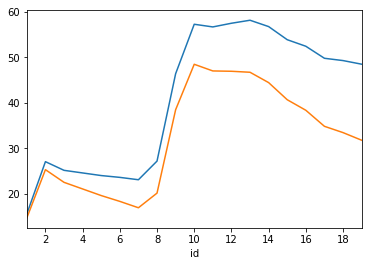

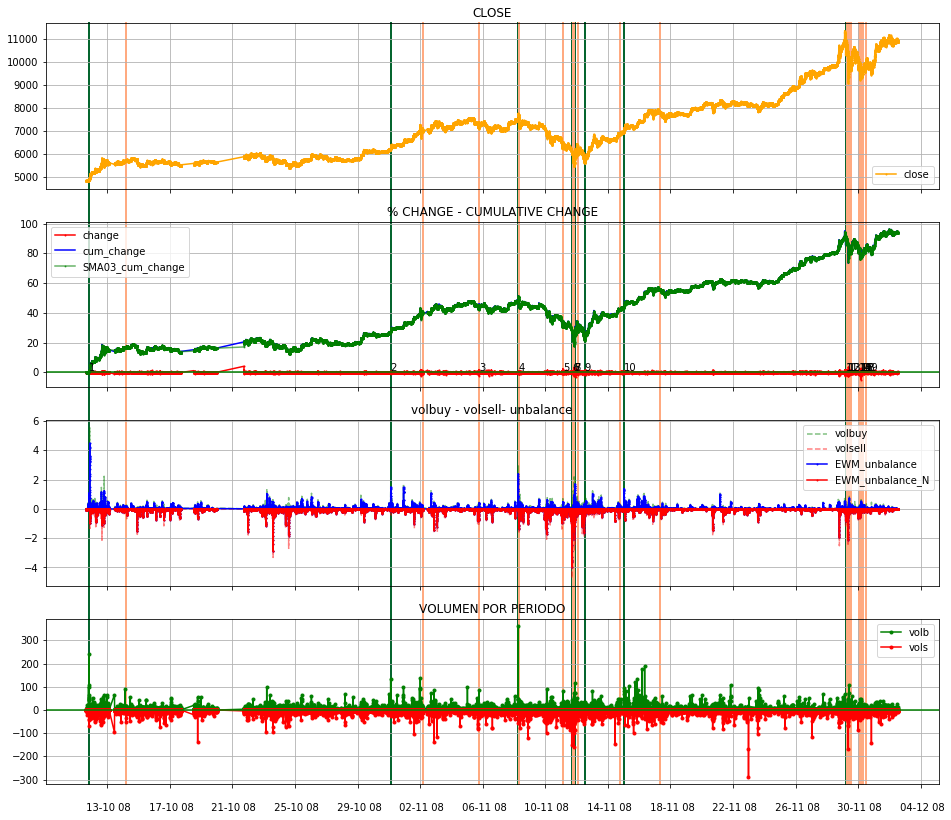

In [76]:
plotProfit()
plotHistory(plotVolume= True, plotTrades=True)

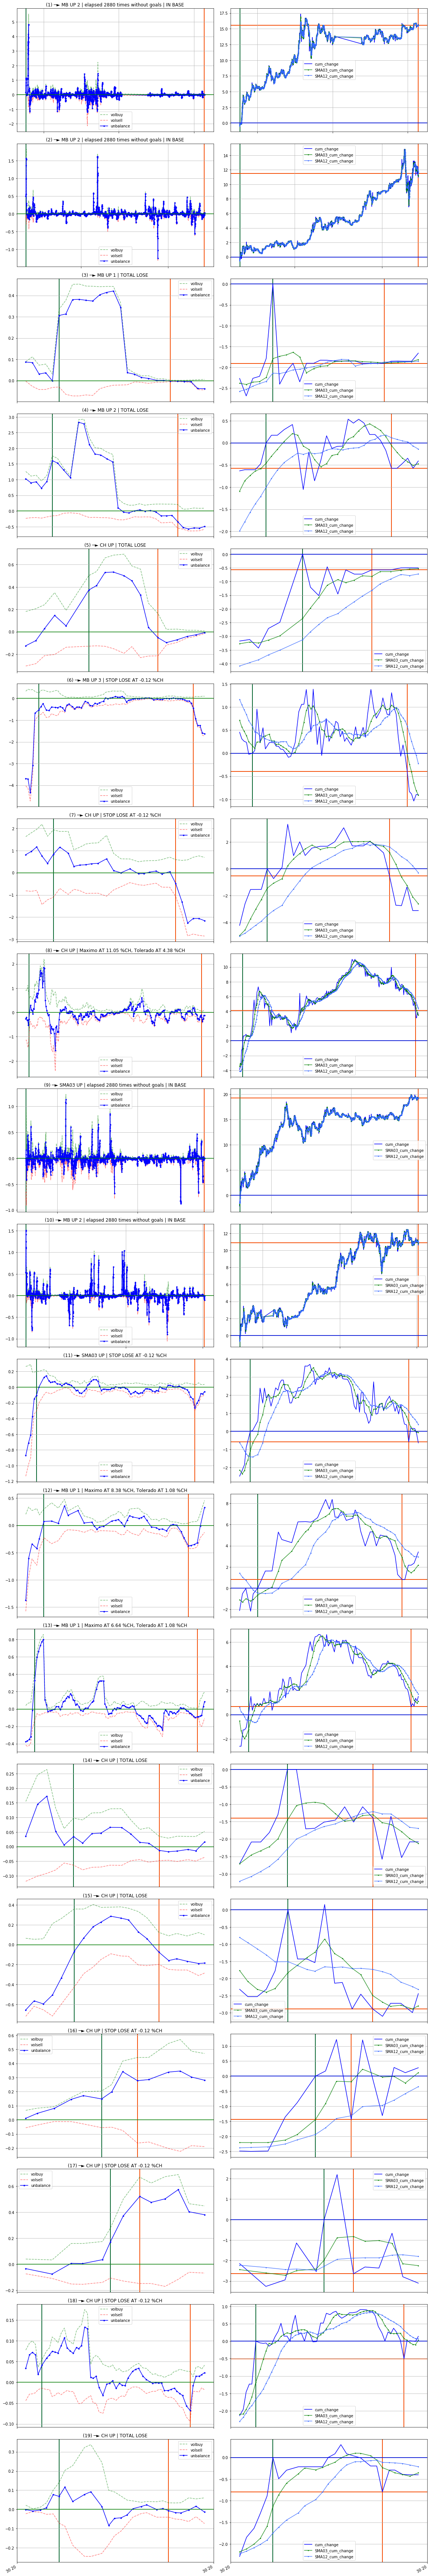

,openTime,closeTime,tradeDescription,OpeningTypeID,ClosingTypeID,openingCH,baseCH,targetCH,stopLoseCH,TotalLoseCH,...,deltaCH,openingP,baseP,targetP,stopLoseP,TotalLoseP,closingP,deltaP,Profit,Profit_Gastos
id,,,,,,,,,,,,,,,,,,,,,
1,2017-10-12 04:24:26.189361,2017-10-14 13:16:28.955507,(1) ─► MB UP 2 | elapsed 2880 times without go...,2,3,1.417575,2.297575,22.297575,1.297575,0.917575,...,15.543815,5128.339535,5173.468923,6199.136830,5122.185527,5153.981233,5759.850000,631.510465,15.543815,14.663815
2,2017-10-31 10:55:48.489882,2017-11-02 11:55:22.490539,(2) ─► MB UP 2 | elapsed 2880 times without go...,2,3,28.402031,29.282031,49.282031,28.282031,27.902031,...,11.491007,6306.792708,6362.292484,7623.651026,6299.224557,6338.326672,7022.700000,715.907292,27.034822,25.274822
3,2017-11-06 02:16:52.300732,2017-11-06 02:33:50.852990,(3) ─► MB UP 1 | TOTAL LOSE,1,4,46.133129,47.013129,67.013129,46.013129,45.633129,...,-1.906993,7342.203947,7406.815342,8875.256132,7333.393303,7378.914967,7272.550000,-69.653947,25.127829,22.487829
4,2017-11-08 14:29:44.980016,2017-11-08 14:55:10.472243,(4) ─► MB UP 2 | TOTAL LOSE,2,4,51.045385,51.925385,71.925385,50.925385,50.545385,...,-0.574373,7728.539130,7796.550275,9342.258101,7719.264883,7767.181826,7695.753125,-32.786005,24.553455,21.033455
5,2017-11-11 10:55:20.149628,2017-11-11 11:04:43.044824,(5) ─► CH UP | TOTAL LOSE,5,4,35.105836,35.985836,55.985836,34.985836,34.605836,...,-0.574868,6441.487500,6498.172590,7786.470090,6433.757715,6473.694937,6505.000000,63.512500,23.978588,19.578588
6,2017-11-12 00:45:13.928669,2017-11-12 01:59:36.868935,(6) ─► MB UP 3 | STOP LOSE AT -0.12 %CH,3,2,26.734294,27.614294,47.614294,26.614294,26.234294,...,-0.399189,6004.473684,6057.313053,7258.207789,5997.268316,6034.496053,5989.677778,-14.795906,23.579399,18.299399
7,2017-11-12 04:13:02.269818,2017-11-12 04:36:15.362498,(7) ─► CH UP | STOP LOSE AT -0.12 %CH,5,2,23.160814,24.040814,44.040814,23.040814,22.660814,...,-0.520737,5774.660563,5825.477576,6980.409689,5767.730971,5803.533866,5776.672917,2.012353,23.058662,16.898662
8,2017-11-12 04:59:04.860829,2017-11-12 10:16:32.494291,"(8) ─► CH UP | Maximo AT 11.05 %CH, Tolerado A...",5,1,23.660222,24.540222,44.540222,23.540222,23.160222,...,4.102796,5807.792105,5858.900676,7020.459097,5800.822755,5836.831066,6033.857143,226.065038,27.161458,20.121458
9,2017-11-12 20:37:04.061815,2017-11-15 02:04:46.260299,(9) ─► SMA03 UP | elapsed 2880 times without g...,4,3,23.154154,24.034154,44.034154,23.034154,22.654154,...,19.211775,5726.872727,5777.269207,6922.643753,5720.000480,5755.507091,6885.850000,1158.977273,46.373232,38.453232


In [77]:
plotAllTrades()
myTrades

In [78]:
deltaVol = tradesCondensation['volb'].sum() + tradesCondensation['vols'].sum()
deltaVol

-8798.4008928700205

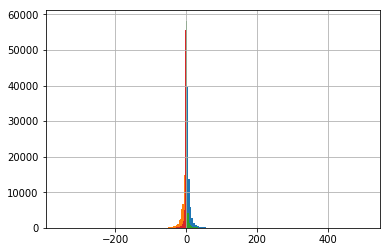

In [79]:
tradesCondensation['countb'].hist(bins=100)
tradesCondensation['counts'].hist(bins=100)
tradesCondensation['volb'].hist(bins=100)
tradesCondensation['vols'].hist(bins=100)

In [80]:
done = time.time()
elapsed = (done - start)/60
print(elapsed)

1.865873392422994


In [81]:
"""
tradesHistory = pd.read_sql(dbTradesHistoryTable, con=engine)
tradesHistory.set_index(pd.DatetimeIndex(tradesHistory['time']),inplace=True)
tradesHistory.head()
tradesHistory.tail(10)
print(tradesCondensation['volb'].last_valid_index())
# limpiar datros corrompidos 
import sqlite3
conn = sqlite3.connect('krakenTeader.db')
c = conn.cursor()
#mydata = c.execute("DELETE FROM TradesCondensation WHERE time=?", ("2102-05-08 07:47:11.736900",))
mydata = c.execute("DELETE FROM TradesCondensation")
conn.commit()
c.close """

'\ntradesHistory = pd.read_sql(dbTradesHistoryTable, con=engine)\ntradesHistory.set_index(pd.DatetimeIndex(tradesHistory[\'time\']),inplace=True)\ntradesHistory.head()\ntradesHistory.tail(10)\nprint(tradesCondensation[\'volb\'].last_valid_index())\n# limpiar datros corrompidos \nimport sqlite3\nconn = sqlite3.connect(\'krakenTeader.db\')\nc = conn.cursor()\n#mydata = c.execute("DELETE FROM TradesCondensation WHERE time=?", ("2102-05-08 07:47:11.736900",))\nmydata = c.execute("DELETE FROM TradesCondensation")\nconn.commit()\nc.close '